In [1]:
import planetary_computer as pc

import numpy as np
import xarray as xr

import stackstac
import pystac_client

import matplotlib.pyplot as plt

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots

from dask.distributed import Client, progress

In [2]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-6jevlve8', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-sl8znylc', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-reku2ynx', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/PlanetaryComputerExamples/tutorials/dask-worker-space/worker-55be073g', purging


### Data ER REGION-Italy Example

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

ids = [
    "S2B_MSIL2A_20210408T100549_R022_T32TPQ_20210524T183323",
    "S2B_MSIL2A_20210816T100559_R022_T32TPQ_20210816T204903",
    "S2A_MSIL2A_20210821T101031_R022_T32TPQ_20210822T004507",
    #"S2A_MSIL2A_20210729T100031_R122_T32TQQ_20210802T014833",
    "S2B_MSIL2A_20211124T101239_R022_T32TPQ_20211124T200956",
]
search = catalog.search(collections=["sentinel-2-l2a"], ids=ids)

In [5]:
items = [pc.sign(item).to_dict() for item in search.get_items()]

data = (
    stackstac.stack(
        items,
        epsg=32619,
        resolution=500,
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        chunksize=256,  # set chunk size to 256 to get one chunk per time step
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ),  # round time to daily for nicer plot labels
    )
)
data

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-e6bc56f1d79befff4b96b2bfc49b2fe0' (time: 4,
                                                                band: 4,
                                                                y: 379, x: 379)>
dask.array<where, shape=(4, 4, 379, 379), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2021-04-08...
    id                                       (time) <U54 'S2B_MSIL2A_20210408...
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 5.948e+06 ... 6.138e+06
  * y                                        (y) float64 8.978e+06 ... 8.788e+06
    s2:thin_cirrus_percentage                (time) float64 1.413 ... 0.00067
    ...                                       ...
    proj:shape                               object {10980}
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(5948500, 8788000, 6138000, 89...
    crs:         epsg:32619
    transform:   | 500.00, 0.00, 5948500.00|\n| 0.00,-500.00, 8977500.00|\n| ...
    resolution:  500

Now lets load up the data. This should take about 30 seconds.

In [6]:
data = data.persist()
progress(data)

VBox()

In [7]:
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.labelleft": False,
    "ytick.left": False,
}

plt.rcParams.update(rc)

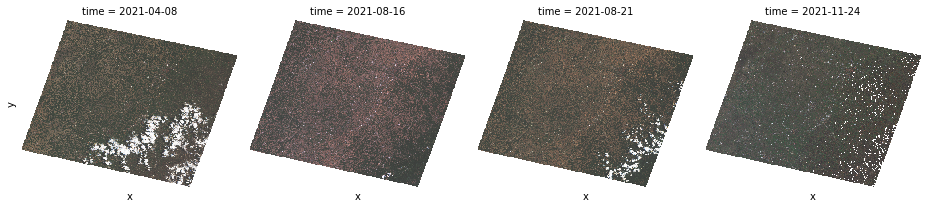

In [8]:
true_color_aggs = [
    ms.true_color(x.sel(band="red"), x.sel(band="green"), x.sel(band="blue"))
    for x in data
]

true_color = xr.concat(true_color_aggs, dim=data.coords["time"])

# visualize
t = true_color.plot.imshow(x="x", y="y", col="time", col_wrap=4)

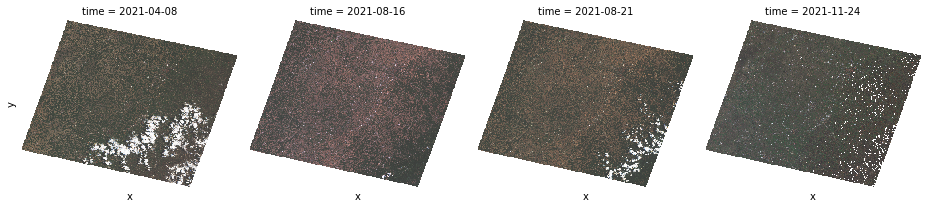

In [9]:
true_color_aggs = [
    ms.true_color(x.sel(band="red"), x.sel(band="green"), x.sel(band="blue"))
    for x in data
]

true_color = xr.concat(true_color_aggs, dim=data.coords["time"])

# visualize
t = true_color.plot.imshow(x="x", y="y", col="time", col_wrap=4)

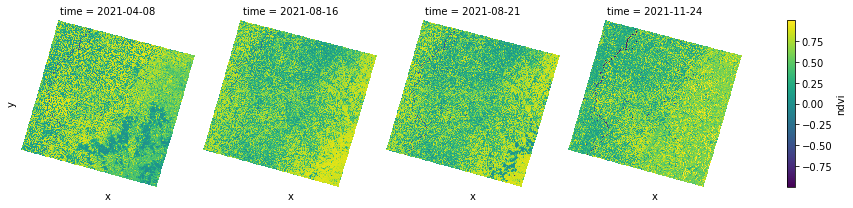

In [10]:
ndvi_aggs = [ms.ndvi(x.sel(band="nir"), x.sel(band="red")) for x in data]

ndvi = xr.concat(ndvi_aggs, dim="time")

ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=4, cmap="viridis");

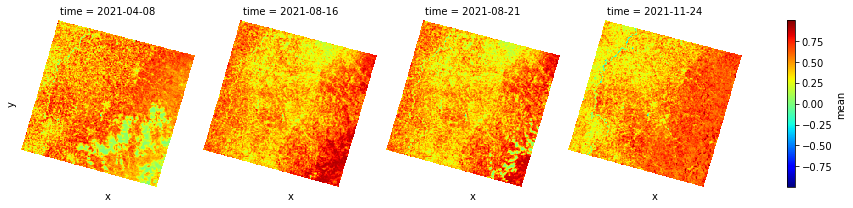

In [11]:
mean_aggs = [mean(ndvi_agg) for ndvi_agg in ndvi_aggs]

smooth = xr.concat(mean_aggs, dim="time")

s = smooth.plot.imshow(x="x", y="y", col="time", col_wrap=4, cmap="jet")

In [24]:
cellsize = calc_cellsize(ndvi)
cellsize

(500.0, 500.0)

In [25]:
kernel = circle_kernel(*cellsize, radius=3 * cellsize[0])
kernel.shape

(7, 7)

In [26]:
%%time
stats_aggs = [focal_stats(ndvi_agg, kernel) for ndvi_agg in ndvi_aggs]

stats = xr.concat(stats_aggs, dim="time")

CPU times: user 352 ms, sys: 0 ns, total: 352 ms
Wall time: 341 ms


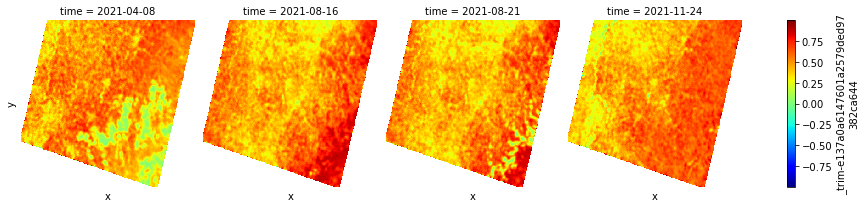

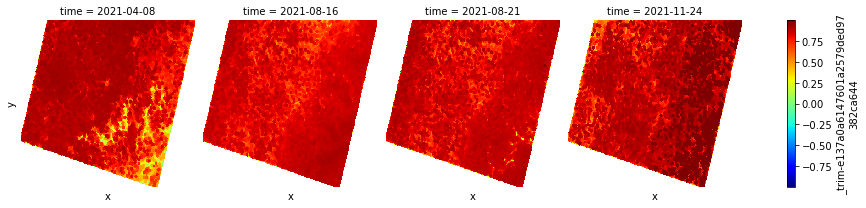

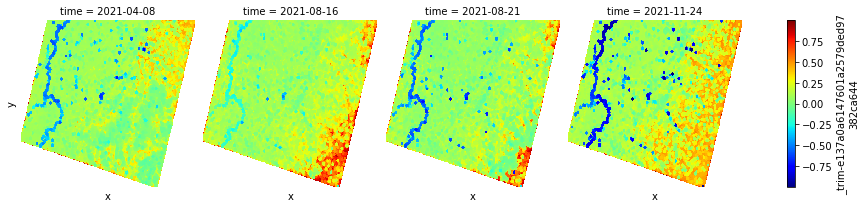

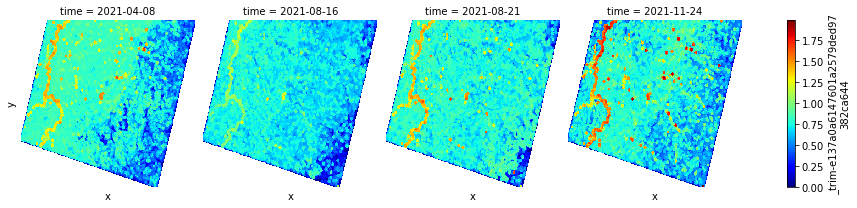

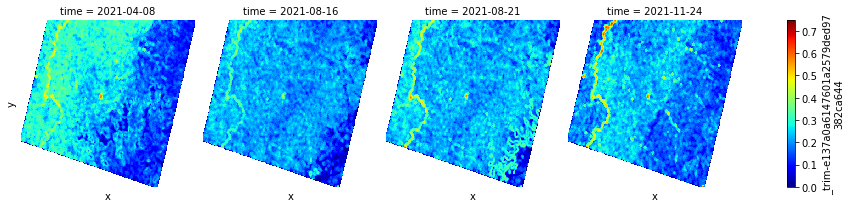

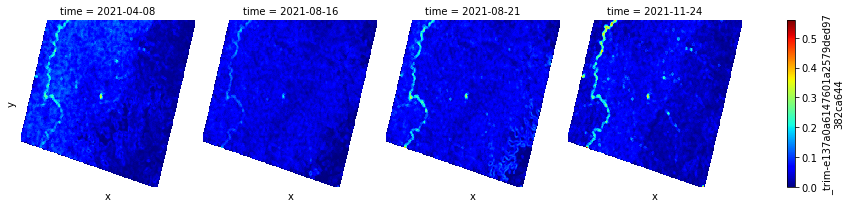

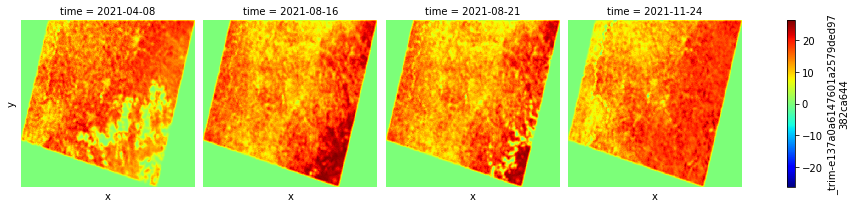

In [27]:
stats_t = stats.transpose("stats", "time", "y", "x")

for stats_img in stats_t:
    g = stats_img.plot.imshow(x="x", y="y", col="time", col_wrap=4, cmap="jet")

In [28]:
sobel_kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

sobel_kernel

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

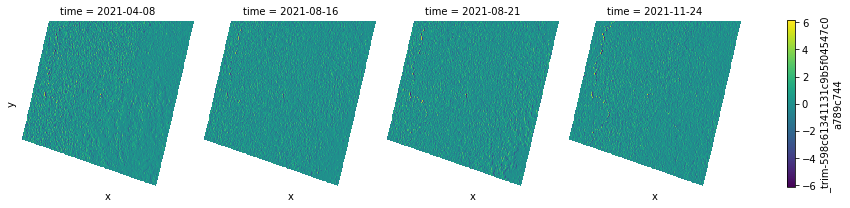

In [29]:
sobel_aggs = [convolution_2d(ndvi_agg, sobel_kernel) for ndvi_agg in ndvi_aggs]

sobel_agg = xr.concat(sobel_aggs, dim="time")

sobel_agg.plot.imshow(x="x", y="y", col="time", col_wrap=4, cmap="viridis");

In [30]:
%%time
hotspots_aggs = [hotspots(ndvi_agg, kernel) for ndvi_agg in ndvi]

hotspots_ndvi = xr.concat(hotspots_aggs, dim="time")

CPU times: user 415 ms, sys: 26 µs, total: 415 ms
Wall time: 407 ms


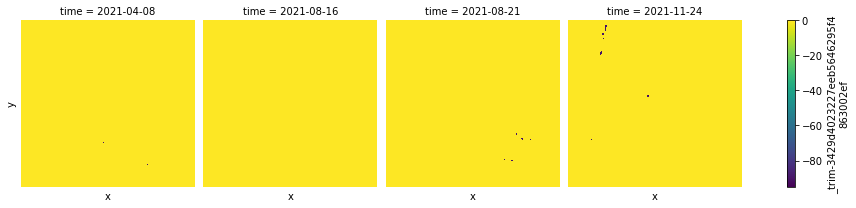

In [31]:
hotspots_ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=4, cmap="viridis");

In [32]:
np.unique(hotspots_ndvi)

array([-95, -90,   0], dtype=int8)